In [1]:
import warnings
import torch
import torchvision
import  numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings('ignore')

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu:0")

In [4]:
in_channel = 3
num_classes = 10
learning_rate = 1e-3
batch_size = 1024
num_epochs = 1

In [5]:
# identity class
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [6]:
import os
os.environ['TORCH_HOME'] = '../pre-trained/' #setting the environment variable

In [7]:
# load pretrained model and modify it
model = torchvision.models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to pre-trained/hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [01:03<00:00, 8.69MB/s] 


In [8]:
# modifying parameters
for param in model.parameters():
    param.requires_grad = False # don't change the weight to that point
model.avgpool = Identity()
# use the array indexing to select specific classifiers (model.classifier[x] = nn.Linear(512, num_classes)
# a sequential layer can also be used to add more linear layers to the classifier, example
model.classifier = nn.Sequential(
    nn.Linear(512, 100),
    nn.ReLU(),
    nn.Linear(100, num_classes)
)
# model.classifier = nn.Linear(512, num_classes)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
train_dataset = datasets.CIFAR10(root='../dataset/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.CIFAR10(root='../dataset/', train=False, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 170498071/170498071 [01:42<00:00, 1665293.63it/s]


Extracting ../dataset/cifar-10-python.tar.gz to ../dataset/
Files already downloaded and verified


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        # set the data to device
        data = data.to(device).squeeze(1)
        targets = targets.to(device)
        
        scores = model(data)
        loss = criterion(scores, targets)
        # backward
        optimizer.zero_grad() # set all gradients to zero for each batch to avoid storing batch forward calculation
        loss.backward()
        # gradient descent or adam step
        optimizer.step() 
        # add the training loss to the train loses
        train_losses.append(loss.item())
        
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
        # set the model to validation mode
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in test_loader:
                x = x.to(device).squeeze(1)
                y = y.to(device)
                prediction = model(x)
                val_loss += criterion(prediction, y).item()
        
        val_loss /= len(test_loader)  # Average validation loss
        val_losses.append(val_loss)
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}')

print("Training and validation completed.")

Epoch [1/1], Step [0/49], Loss: 2.3138
Epoch [1/1], Validation Loss: 2.2680
Training and validation completed.


In [12]:
model_path = f"../models/vgg_16_fine_tuned.pth"

In [13]:
# save the model
torch.save(model.state_dict(), model_path)

In [14]:
model.load_state_dict(torch.load(model_path))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
x = np.arange(1, len(train_losses) + 1)

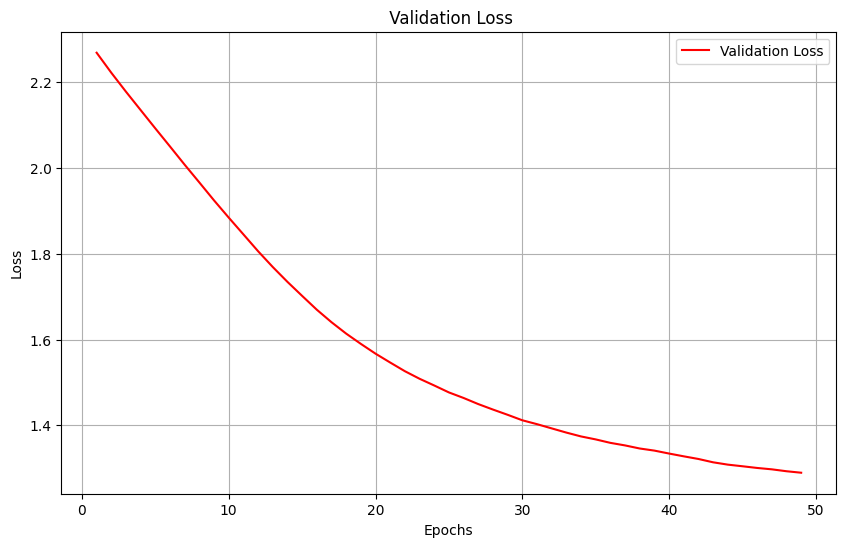

In [16]:
# plot the validation loss
plt.figure(figsize=(10, 6))
plt.plot(x, val_losses, label="Validation Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(" Validation Loss")
plt.grid(True)
plt.legend()
plt.show()

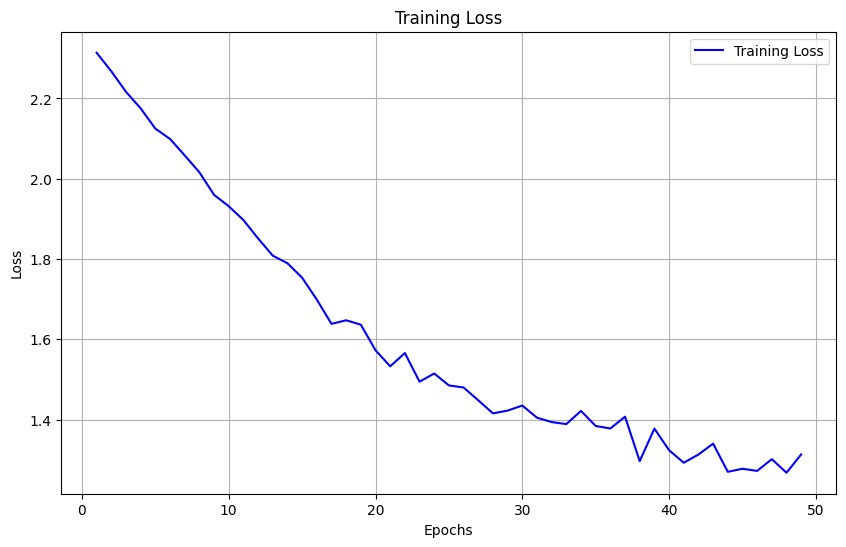

In [17]:
# plot the training
plt.figure(figsize=(10, 6))
plt.plot(x, train_losses, label="Training Loss", color='blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.legend()
plt.show()

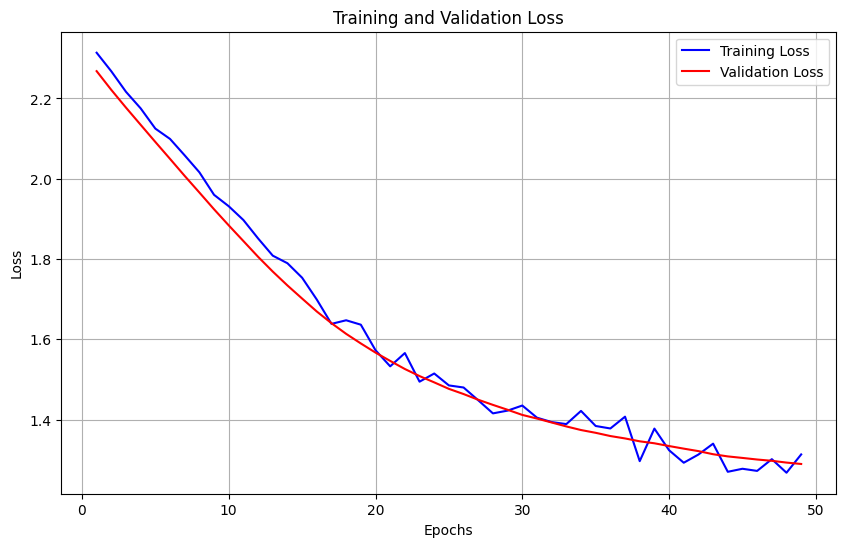

In [18]:
# plot the training and validation loss 
plt.figure(figsize=(10, 6))
plt.plot(x, train_losses, label="Training Loss", color='blue')
plt.plot(x, val_losses, label="Validation Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.grid(True)
plt.legend()
plt.show()

In [19]:
# check for the accuracy of the model
def check_accuracy(loader, trained_model):
    num_correct = 0
    num_samples = 0
    trained_model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device).squeeze(1)
            y = y.to(device)
            pred_scores = trained_model(x)
            _, predictions = pred_scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
            
    print(f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100}")
    print(f"Accuracy: {float(num_correct)/float(num_samples)*100}")

In [20]:
check_accuracy(test_loader, model)

Got 5527 / 10000 with accuracy 55.269999999999996
Accuracy: 55.269999999999996
